<a href="https://colab.research.google.com/github/BuckyI/Homework-AMFCS/blob/master/chapter2/%E7%AC%AC%E4%BA%8C%E9%A2%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

深度学习训练方法总结

数据集：kddcup99.zip

任务描述：实现一个简单的神经网络模型判别数据包是否为 attack，网络层数不小于 5 层，
平台不限（TensorFlow、Pytorch 等都可），例如 42->36->24->12->6->1。尝试至少 2 种
激活函数，至少 2 种 parameter initialization 方法，至少 2 种训练方法（SGD，SGD+Momentom，Adam），训练模型并判断训练结果

要求输出：
1. 模型描述，层数，每一层参数，激活函数选择，loss 函数设置等；\
2. 针对不同方法组合（至少 4 个组合），plot 出随着 epoch 增长 training error 的 test error 的变化情况。

> 在 colab 上运行，文件路径是谷歌云盘上的

# 一个简单的神经网络例子

此部分不是作业内容，仅用于测试和学习  
参考网页：https://towardsdatascience.com/your-first-neural-network-in-pytorch-725631ae0fc

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

data import

In [2]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris['data']
y = iris['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

  

define a network

- Criterion: basically how we measure loss, we’ll use `CrossEntropyLoss`
- Optimizer: optimization algorithm, we’ll use `Adam` with a learning rate of `0.01`

In [3]:
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=4, out_features=16)
        self.fc2 = nn.Linear(in_features=16, out_features=12)
        self.output = nn.Linear(in_features=12, out_features=3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)
        return x

model = ANN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

<!-- 代价函数变化曲线：![](https://raw.githubusercontent.com/BuckyI/QnVja3lQaWN0dXJl/main/img/202212122152005.png) -->

Epoch: 0 Loss: 1.281901240348816
Epoch: 10 Loss: 0.9437583684921265
Epoch: 20 Loss: 0.8070077300071716
Epoch: 30 Loss: 0.7072391510009766
Epoch: 40 Loss: 0.5758560299873352
Epoch: 50 Loss: 0.4110664427280426
Epoch: 60 Loss: 0.26909902691841125
Epoch: 70 Loss: 0.16142068803310394
Epoch: 80 Loss: 0.10058241337537766
Epoch: 90 Loss: 0.07475380599498749
CPU times: user 136 ms, sys: 513 ms, total: 650 ms
Wall time: 720 ms


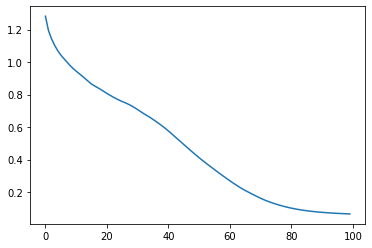

In [4]:
%%time
epochs = 100
loss_arr = []
for i in range(epochs):
   y_hat = model.forward(X_train)
   loss = criterion(y_hat, y_train)
   loss_arr.append(float(loss))
 
   if i % 10 == 0:
       print(f'Epoch: {i} Loss: {loss}')
 
   optimizer.zero_grad()
   loss.backward()
   optimizer.step()
else:
  plt.plot(loss_arr)

Model Evaluation

这部分通过循环，依次取出一份样本，然后前向传播计算结果，并保存结果。运算效率比较低，实际上感觉矩阵运算就可以了。

In [5]:
preds = []
with torch.no_grad():
   for val in X_test:
       y_hat = model.forward(val)
       preds.append(y_hat.argmax().item())


In [6]:
df = pd.DataFrame({'Y': y_test, 'YHat': preds})
df['Correct'] = [1 if corr == pred else 0 for corr, pred in zip(df['Y'], df['YHat'])]

accuracy = df['Correct'].sum() / len(df)
accuracy

1.0

# 作业代码


In [7]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torch.nn.functional as F

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt  # 绘图
%matplotlib inline
# %config InlineBackend.figure_format = 'svg'

from tqdm import tqdm # process bar

# from sklearn import ensemble
# from sklearn import metrics
# from sklearn import model_selection
import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(1)    # reproducible
# use gpu
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## 数据导入与预处理

原始数据有字符串类型（categorical），这里使用 LabelEncoder 编码成数值类型。（类别少的时候也许使用独热码会更好？）

train & test data 合并起来，可以把所有出现的情况都编码。

- 使用 pandas 读取 csv 好像比 numpy 更方便一点，因为源数据并非全部是数值型的。
- 不过后面数据全部转化为数值型后，转化为 numpy 进行索引操作更方便

（还不是因为使用不熟练……只好混着用）

In [8]:
from sklearn.preprocessing import LabelEncoder

kddcup99_train='/content/drive/MyDrive/Colab Notebooks/assets/kddcup99_train.csv'
kddcup99_test='/content/drive/MyDrive/Colab Notebooks/assets/kddcup99_test.csv'
train_data = pd.read_csv(kddcup99_train,encoding="utf-8",error_bad_lines=False,header=None)
test_data = pd.read_csv(kddcup99_test,encoding="utf-8",error_bad_lines=False,header=None)

# Convert categorical variable into dummy/indicator variables.
encoders = {}
data = pd.concat([train_data, test_data],axis=0)
for i in [1, 2, 3, 41]:
    enc = LabelEncoder().fit(data[i])
    train_data[i] = enc.transform(train_data[i])
    test_data[i] = enc.transform(test_data[i])
    encoders[i] = enc

train_data[41]=train_data[41].apply(lambda x: 0 if x==11 else 1) # 0 normal 1 abnormal
test_data[41]=test_data[41].apply(lambda x: 0 if x==11 else 1) # 0 normal 1 abnormal
# next transform to numpy cause i dont know pandas well qwq...
train_data = train_data.to_numpy()
test_data = test_data.to_numpy()
print("shape", train_data.shape, test_data.shape)

b'Skipping line 3854675: expected 42 fields, saw 56\n'


shape (3919781, 42) (978649, 42)


将 numpy 转化为 Tensor，这里 `.to(device)` 可以进行加速

注意 FloatTensor 指转化为 Float 类型的 Tensor，这与后面的代码兼容。在某些情况下。可能需要 Long 类型的 Tensor。

In [9]:
X_train = torch.FloatTensor(train_data[:, 0:-1]).to(device)
y_train = torch.FloatTensor(train_data[:, -1]).to(device)
X_test = torch.FloatTensor(test_data[:, 0:-1]).to(device)
y_test = torch.FloatTensor(test_data[:, -1]).to(device)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([3919781, 41])
torch.Size([3919781])
torch.Size([978649, 41])
torch.Size([978649])


## 基本模型训练

> 这里建立一个基本的模型进行训练，后面在此基础上更改参数之类的

输入数据特征为 41 维，输出数据为 01 二分类。

- 采用 41x36x24x12x6x1 的网络结构
- 激活函数中间层普遍使用relu，输出层激活函数则是要根据任务配合loss来选择。这里是二分类问题，可以采用sigmoid和交叉熵。

```
UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
```

In [10]:
class Net(nn.Module):
    def __init__(self, act=F.relu):
        super().__init__()
        self.hidden1 = torch.nn.Linear(41, 36)   # hidden layer
        self.hidden2 = torch.nn.Linear(36, 24)   # hidden layer
        self.hidden3 = torch.nn.Linear(24, 12)   # hidden layer
        self.hidden4 = torch.nn.Linear(12, 6)   # hidden layer
        self.predict = torch.nn.Linear(6, 1)   # output layer

        self.act = act  # 激活函数
        self.train_error = []  # 训练误差
        self.test_error = []  # 测试误差

    def forward(self, x):
        x = self.act(self.hidden1(x))
        x = self.act(self.hidden2(x))
        x = self.act(self.hidden3(x))
        x = self.act(self.hidden4(x))
        x = F.sigmoid(self.predict(x)) # 二分类，输出层激活函数设为 sigmoid
        return x




- 建立网络实例：放到 GPU 里面加速
- 设置训练相关参数：代价函数，参数优化方法
- 训练网络

attention: 
- 性能评价函数 loss function (criterion) 和 参数优化器 optimizer 不能放到网络里面~
- 遇到一个错误大概是说 Tensor 的形状不一样，`(n, )` 和 `(n, 1)`。  
`y_hat.squeeze()` 减少了一个维度，`y_hat.unsqueeze(1)` 增加了一个维度，具体原理不懂 :)

> https://stackoverflow.com/questions/57798033/valueerror-target-size-torch-size16-must-be-the-same-as-input-size-torch


100%|██████████| 50/50 [00:05<00:00,  8.36it/s]


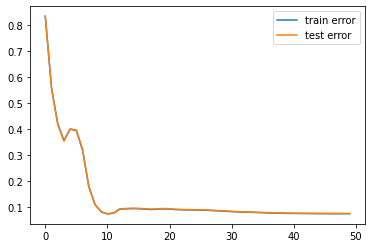

In [11]:
epochs =50

model = Net().to(device)
criterion = nn.BCELoss()  # 二分类使用
# criterion = nn.CrossEntropyLoss()  # 多分类使用
# mse_loss = nn.MSELoss()  # 均方误差 用这个评价测试误差和训练误差
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for i in tqdm(range(epochs)):
    y_hat = model(X_train)
    y_hat = y_hat.squeeze()
    loss = criterion(y_hat, y_train)

    # save nessensary data (divide by the number of samples)
    model.train_error.append(float(loss))
    with torch.no_grad():
        y_test_hat = model(X_test)
        y_test_hat = y_test_hat.squeeze()
        model.test_error.append(float(criterion(y_test_hat, y_test)))

    # update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
   
else:
    plt.plot(model.train_error, label='train error')
    plt.plot(model.test_error, label='test error')
    plt.legend()


<!-- ![](https://raw.githubusercontent.com/BuckyI/QnVja3lQaWN0dXJl/main/img/202212122153279.png) -->

### 准确度测试

> TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

由于是二分类问题，网络输出值为 0-1，~~因此用下面的方法计算准确度~~。会导致内存不够，不知道怎么判断了……


In [12]:
# with torch.no_grad():
#     y_hat = model(X_test)

#     result = y_hat.cpu().numpy() > 0.5


这部分是取出一部分测试数据进行判断

In [13]:
# preds = []
# pred_num = 500

# with torch.no_grad():
#    for val in X_test[:pred_num,:]:
#        y_hat = model.forward(val)
#        preds.append(y_hat.argmax().item())

# df = pd.DataFrame({'Y': y_test[:pred_num], 'YHat': preds})
# df['Correct'] = [1 if corr == pred else 0 for corr, pred in zip(df['Y'], df['YHat'])]

# accuracy = df['Correct'].sum() / len(df)
# accuracy

## 尝试不同的训练方法


100%|██████████| 50/50 [00:21<00:00,  2.31it/s]


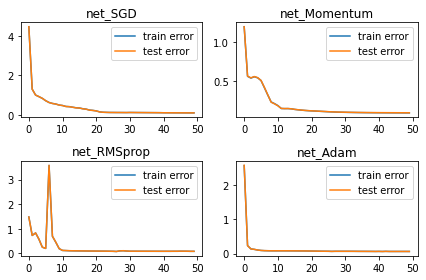

In [14]:

net_type = ['net_SGD', 'net_Momentum', 'net_RMSprop', 'net_Adam']

# 为每个优化器创建一个 net
nets = {
    'net_SGD': Net().to(device),
    'net_Momentum': Net().to(device),
    'net_RMSprop': Net().to(device),
    'net_Adam': Net().to(device)
}


# different optimizers
LR=0.01
optimizers = {
    'opt_SGD': torch.optim.SGD(nets['net_SGD'].parameters(), lr=LR), 
    'opt_Momentum': torch.optim.SGD(nets['net_Momentum'].parameters(), lr=LR, momentum=0.8), 
    'opt_RMSprop': torch.optim.RMSprop(nets['net_RMSprop'].parameters(), lr=LR, alpha=0.9), 
    'opt_Adam': torch.optim.Adam(nets['net_Adam'].parameters(), lr=LR, betas=(0.9, 0.99))
}

loss_func = torch.nn.BCELoss()  # 二分类使用
mse = nn.MSELoss()

epochs = 50

for epoch in tqdm(range(epochs)):
    # 对每个优化器, 优化属于他的神经网络
    for model, optimizer in zip(nets.values(), optimizers.values()):
        y_hat = model(X_train)
        y_hat = y_hat.squeeze()
        loss = loss_func(y_hat, y_train)
        
        # save nessensary data
        model.train_error.append(float(loss))
        with torch.no_grad():
            y_test_hat = model(X_test)
            y_test_hat = y_test_hat.squeeze()
            model.test_error.append(float(loss_func(y_test_hat, y_test)))
        
        # update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
else:
    for i, name in enumerate(net_type):
        model = nets[name]
        plt.subplot(2,2,i+1)
        plt.plot(model.train_error, label='train error')
        plt.plot(model.test_error, label='test error')
        plt.title(name)
        plt.legend()
        plt.tight_layout()

动量项反映了过去调整权值的经验，可以在某种程度上加速收敛（参考曲线后半段，由于临近极值点，导数小，SGD收敛速度比Momentum慢）  
不过Adam结构收敛速度最快！

<!-- ![](https://raw.githubusercontent.com/BuckyI/QnVja3lQaWN0dXJl/main/img/202212122153146.png) -->

使用 sigmoid 激活函数

100%|██████████| 200/200 [01:26<00:00,  2.31it/s]


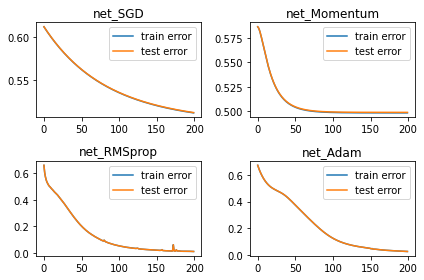

In [15]:
net_type = ['net_SGD', 'net_Momentum', 'net_RMSprop', 'net_Adam']

# 为每个优化器创建一个 net
nets = {
    'net_SGD': Net(F.sigmoid).to(device),
    'net_Momentum': Net(F.sigmoid).to(device),
    'net_RMSprop': Net(F.sigmoid).to(device),
    'net_Adam': Net(F.sigmoid).to(device)
}


# different optimizers
LR=0.01
optimizers = {
    'opt_SGD': torch.optim.SGD(nets['net_SGD'].parameters(), lr=LR), 
    'opt_Momentum': torch.optim.SGD(nets['net_Momentum'].parameters(), lr=LR, momentum=0.8), 
    'opt_RMSprop': torch.optim.RMSprop(nets['net_RMSprop'].parameters(), lr=LR, alpha=0.9), 
    'opt_Adam': torch.optim.Adam(nets['net_Adam'].parameters(), lr=LR, betas=(0.9, 0.99))
}

loss_func = torch.nn.BCELoss()  # 二分类使用
mse = nn.MSELoss()

epochs = 200

for epoch in tqdm(range(epochs)):
    # 对每个优化器, 优化属于他的神经网络
    for model, optimizer in zip(nets.values(), optimizers.values()):
        y_hat = model(X_train)
        y_hat = y_hat.squeeze()
        loss = loss_func(y_hat, y_train)
        
        # save nessensary data
        model.train_error.append(float(loss))
        with torch.no_grad():
            y_test_hat = model(X_test)
            y_test_hat = y_test_hat.squeeze()
            model.test_error.append(float(loss_func(y_test_hat, y_test)))
        
        # update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
else:
    for i, name in enumerate(net_type):
        model = nets[name]
        plt.subplot(2,2,i+1)
        plt.plot(model.train_error, label='train error')
        plt.plot(model.test_error, label='test error')
        plt.title(name)
        plt.legend()
        plt.tight_layout()

隐含层激活函数采用了 sigmoid 函数，层数较多，存在梯度丢失的问题，收敛速度都变慢了。  
在这种情况下添加 momentum 的效果是最好的。

<!-- ![](https://raw.githubusercontent.com/BuckyI/QnVja3lQaWN0dXJl/main/img/202212122156543.png) -->